In [1]:
import importlib
from utils import *
utils = importlib.import_module('utils')
importlib.reload(utils)

from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

In [2]:
feature_list = ['lbp', 'gabor']

In [3]:
ref_dir = 'chocolate-recognition-classic/dataset_project_iapr2025/references/'
ref_image_names = os.listdir(ref_dir)
ref_images = [cv2.imread(os.path.join(ref_dir, img)) for img in ref_image_names]
ref_images = [cv2.resize(img, (img.shape[1] // 4, img.shape[0] // 4)) for img in ref_images]
ref_images_rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in ref_images]
ref_images_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in ref_images]

In [4]:
def find_mask(img_gray: np.ndarray, name: str) -> np.ndarray:
    edges = canny(img_gray)
    
    if "White" in name or "Comtesse" in name:
        result = hough_ellipse(edges, accuracy=20, threshold=4, min_size=4)
        result.sort(order='accumulator')

        best = list(result[-1])
        yc, xc, a, b = (int(round(x)) for x in best[1:5])
        orientation = best[5]

        cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
        edges = np.zeros(img_gray.shape)
        edges[cy, cx] = 1
        
    kernel = np.ones((5,5))
    edges = closing(edges, kernel)
    mask = remove_small_holes(edges.astype(dtype=np.bool), area_threshold=500000)
    mask = opening(mask)

    return mask

In [5]:
overlap_ratio = 0.5  # 50% overlap

bbox_coords = []
bbox_sizes = []
masks = []

for name, image in zip(ref_image_names, ref_images_gray):
    masks.append(find_mask(img_gray=image, name=name))

max_height = 0
max_width = 0

for i, mask in enumerate(masks):
    ys, xs = np.where(mask)
    y_min, y_max = ys.min(), ys.max()
    x_min, x_max = xs.min(), xs.max()

    h = y_max - y_min
    w = x_max - x_min
    bbox_coords.append((y_min, y_max, x_min, x_max))
    bbox_sizes.append((h, w))

    max_height = max(max_height, h)
    max_width = max(max_width, w)

min_height = min(h for h, w in bbox_sizes)
min_width = min(w for h, w in bbox_sizes)
min_size = (min_height // 2, min_width // 2)

stride_y = int(min_size[0] * (1 - overlap_ratio))
stride_x = int(min_size[1] * (1 - overlap_ratio))

reference_feature_vectors = []
selected_bbox_coords = []

for i in range(len(ref_images)):
    y_min, y_max, x_min, x_max = bbox_coords[i]
    mask = masks[i].astype(np.uint8) * 255

    reference_features = []

    for y in range(y_min, y_max - min_size[0] + 1, stride_y):
        for x in range(x_min, x_max - min_size[1] + 1, stride_x):
            tile_mask = mask[y:y+min_size[0], x:x+min_size[1]]
            coverage = np.sum(tile_mask) / (min_size[0] * min_size[1] * 255)

            if coverage >= 0.9:
                roi = ref_images[i][y:y+min_size[0], x:x+min_size[1]]
                roi_mask = tile_mask
                feature_vec = extract_masked_features(roi, roi_mask, feature_list=feature_list)
                reference_features.append(feature_vec)
                selected_bbox_coords.append((i, y, y + min_size[0], x, x + min_size[1]))

    reference_feature_vectors.append(reference_features)

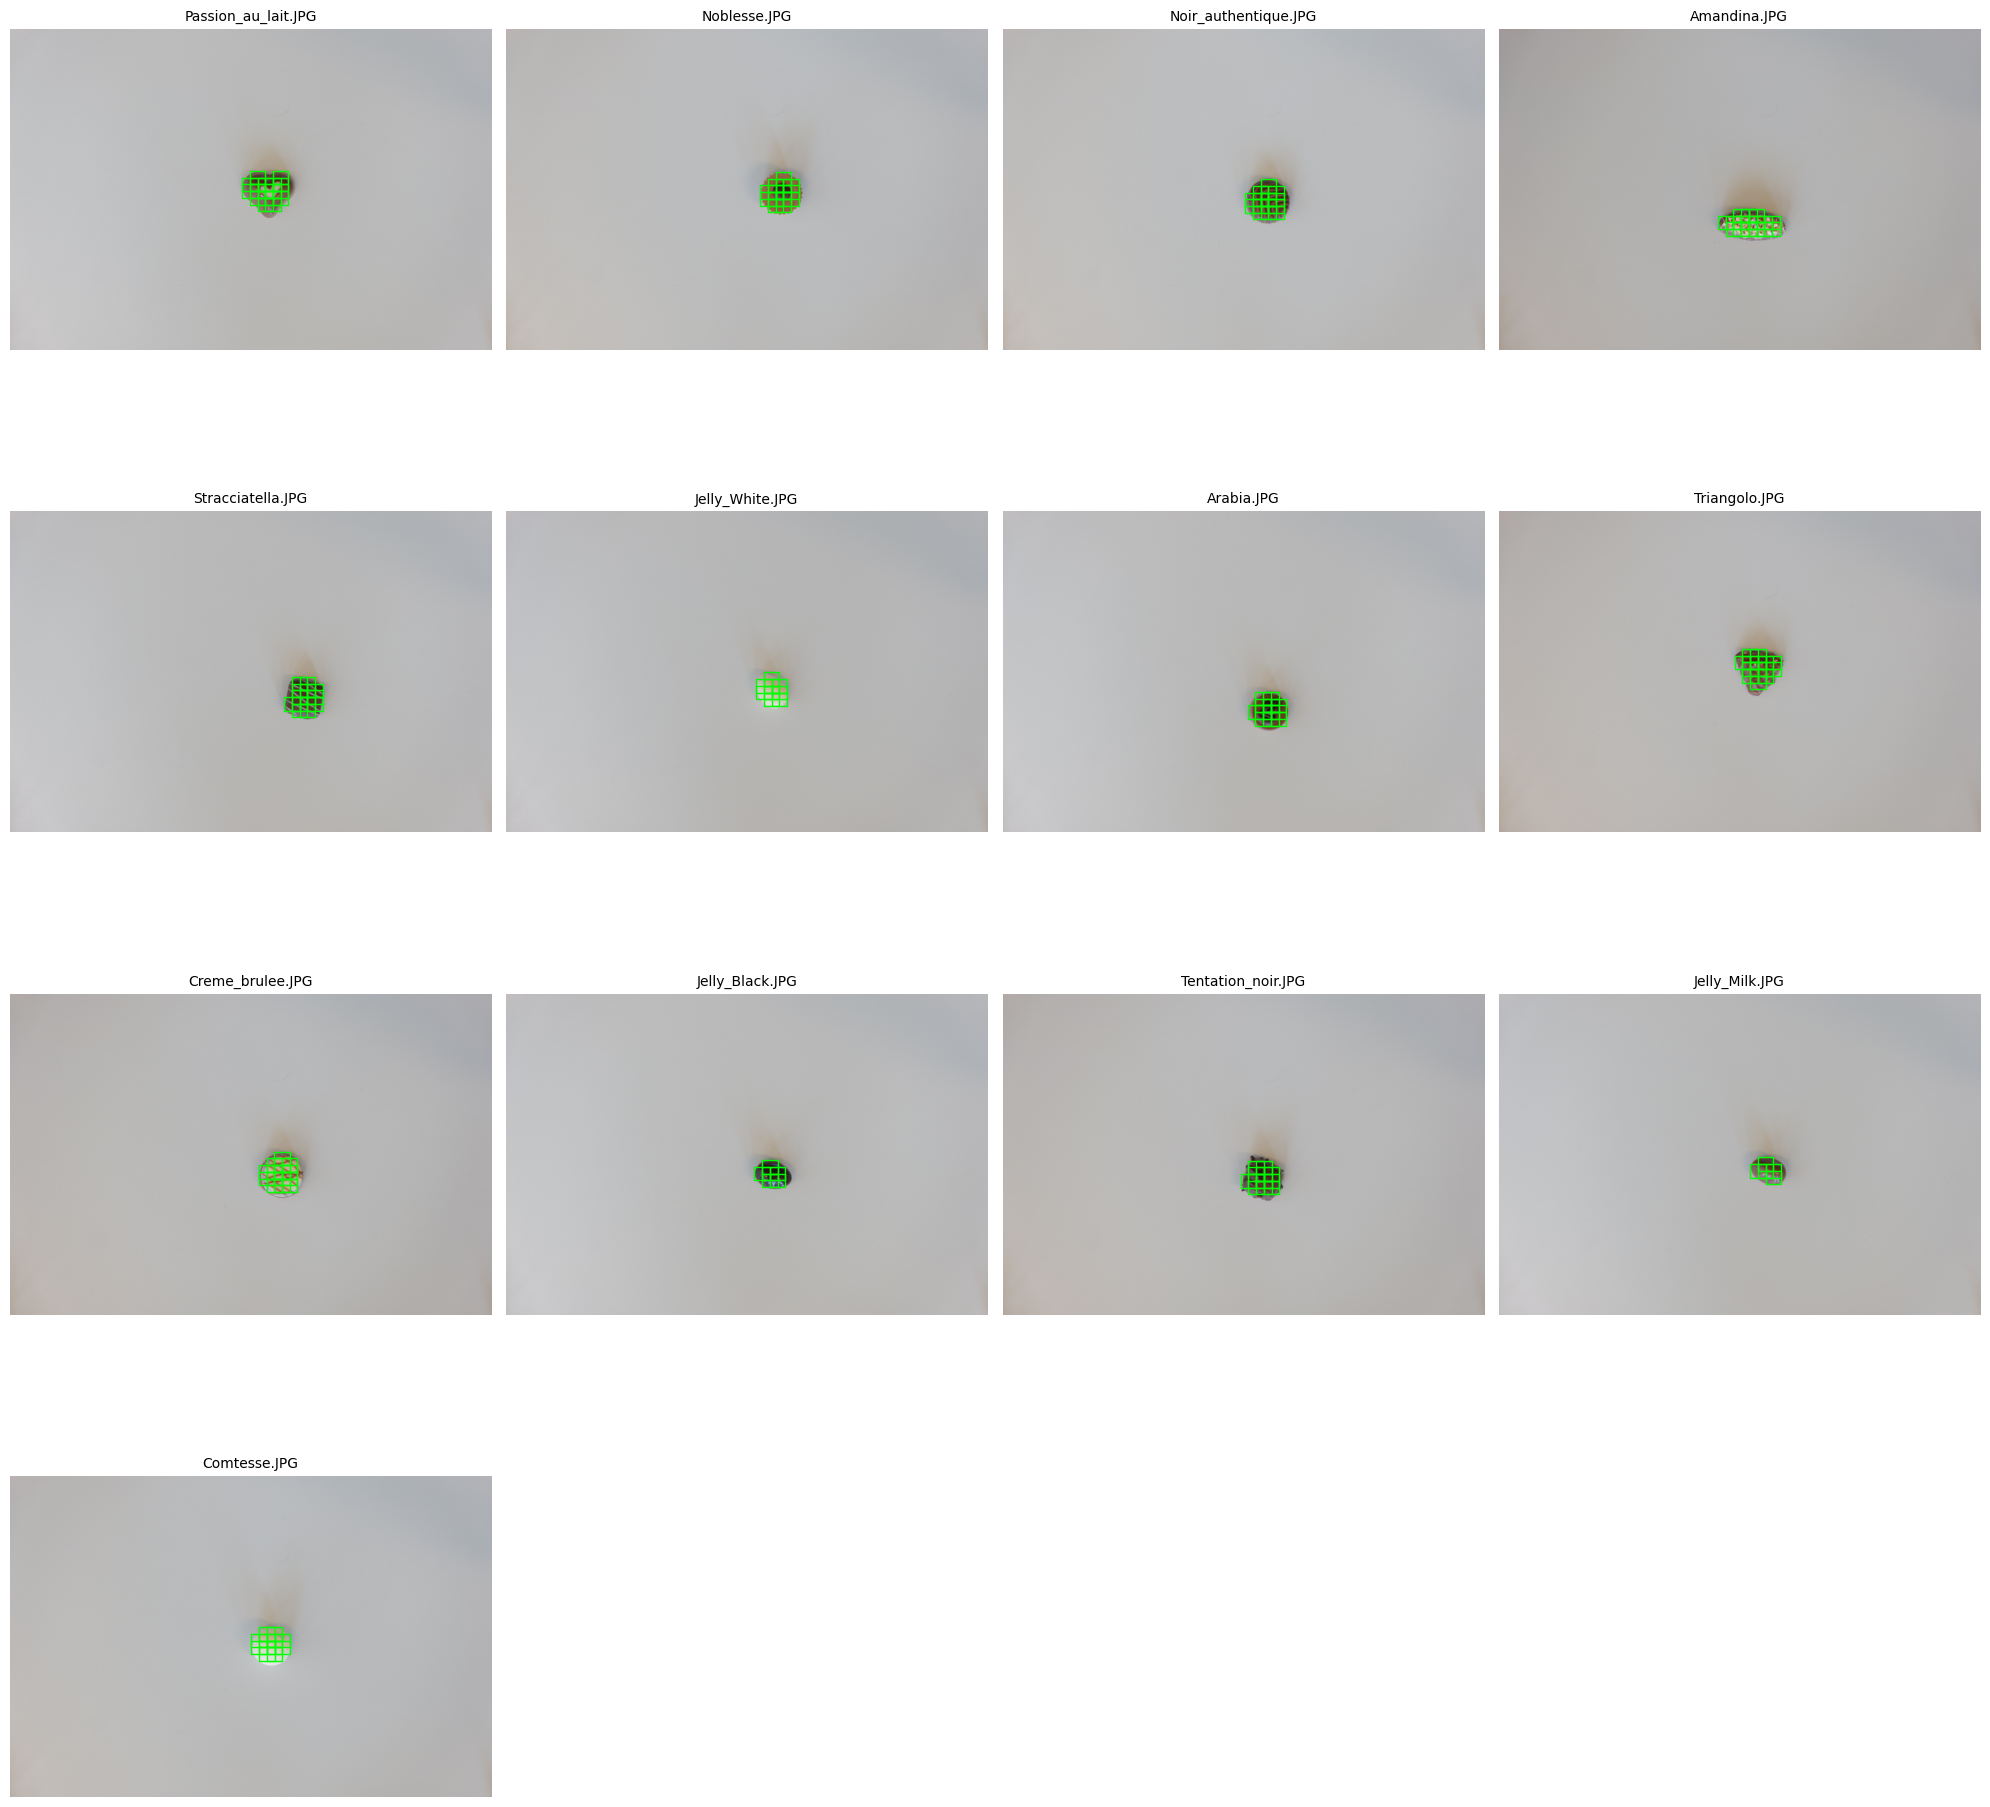

In [6]:
cols = 4
rows = int(np.ceil(len(ref_image_names) / cols))
plt.figure(figsize=(5 * cols, 5 * rows))

for i, name in enumerate(ref_image_names):
    img = cv2.cvtColor(ref_images[i], cv2.COLOR_BGR2RGB)
    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(img)

    for idx, y1, y2, x1, x2 in selected_bbox_coords:
        if idx == i:
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=1, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)

    ax.set_title(name, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
print("Shape of reference feature vectors:", len(reference_feature_vectors), len(reference_feature_vectors[0]), len(reference_feature_vectors[0][0]))

Shape of reference feature vectors: 13 18 42


PCA to reduce the dimensionality of the data

Cumvar >= 0.95: 4


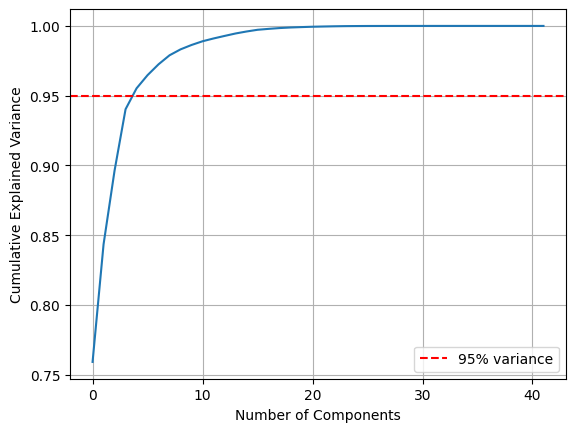

In [8]:
from sklearn.decomposition import PCA

feature_array = np.vstack(reference_feature_vectors)

pca = PCA().fit(feature_array) 

# Cumulative explained variance
cum_var = np.cumsum(pca.explained_variance_ratio_)

print("Cumvar >= 0.95:", np.where(cum_var >= 0.95)[0][0])

# Plot
plt.plot(cum_var)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)

In [9]:
pca = PCA(n_components=31)

new_array = pca.fit_transform(feature_array)

patch_counts = [len(patches) for patches in reference_feature_vectors]

reduced_feature_vectors = []
start = 0
for count in patch_counts:
    end = start + count
    reduced_feature_vectors.append(new_array[start:end])
    start = end

print("Shape of reduced feature vectors:", len(reduced_feature_vectors), len(reduced_feature_vectors[0]), len(reduced_feature_vectors[0][0]))

reduced_array = np.vstack(reduced_feature_vectors)

Shape of reduced feature vectors: 13 18 31


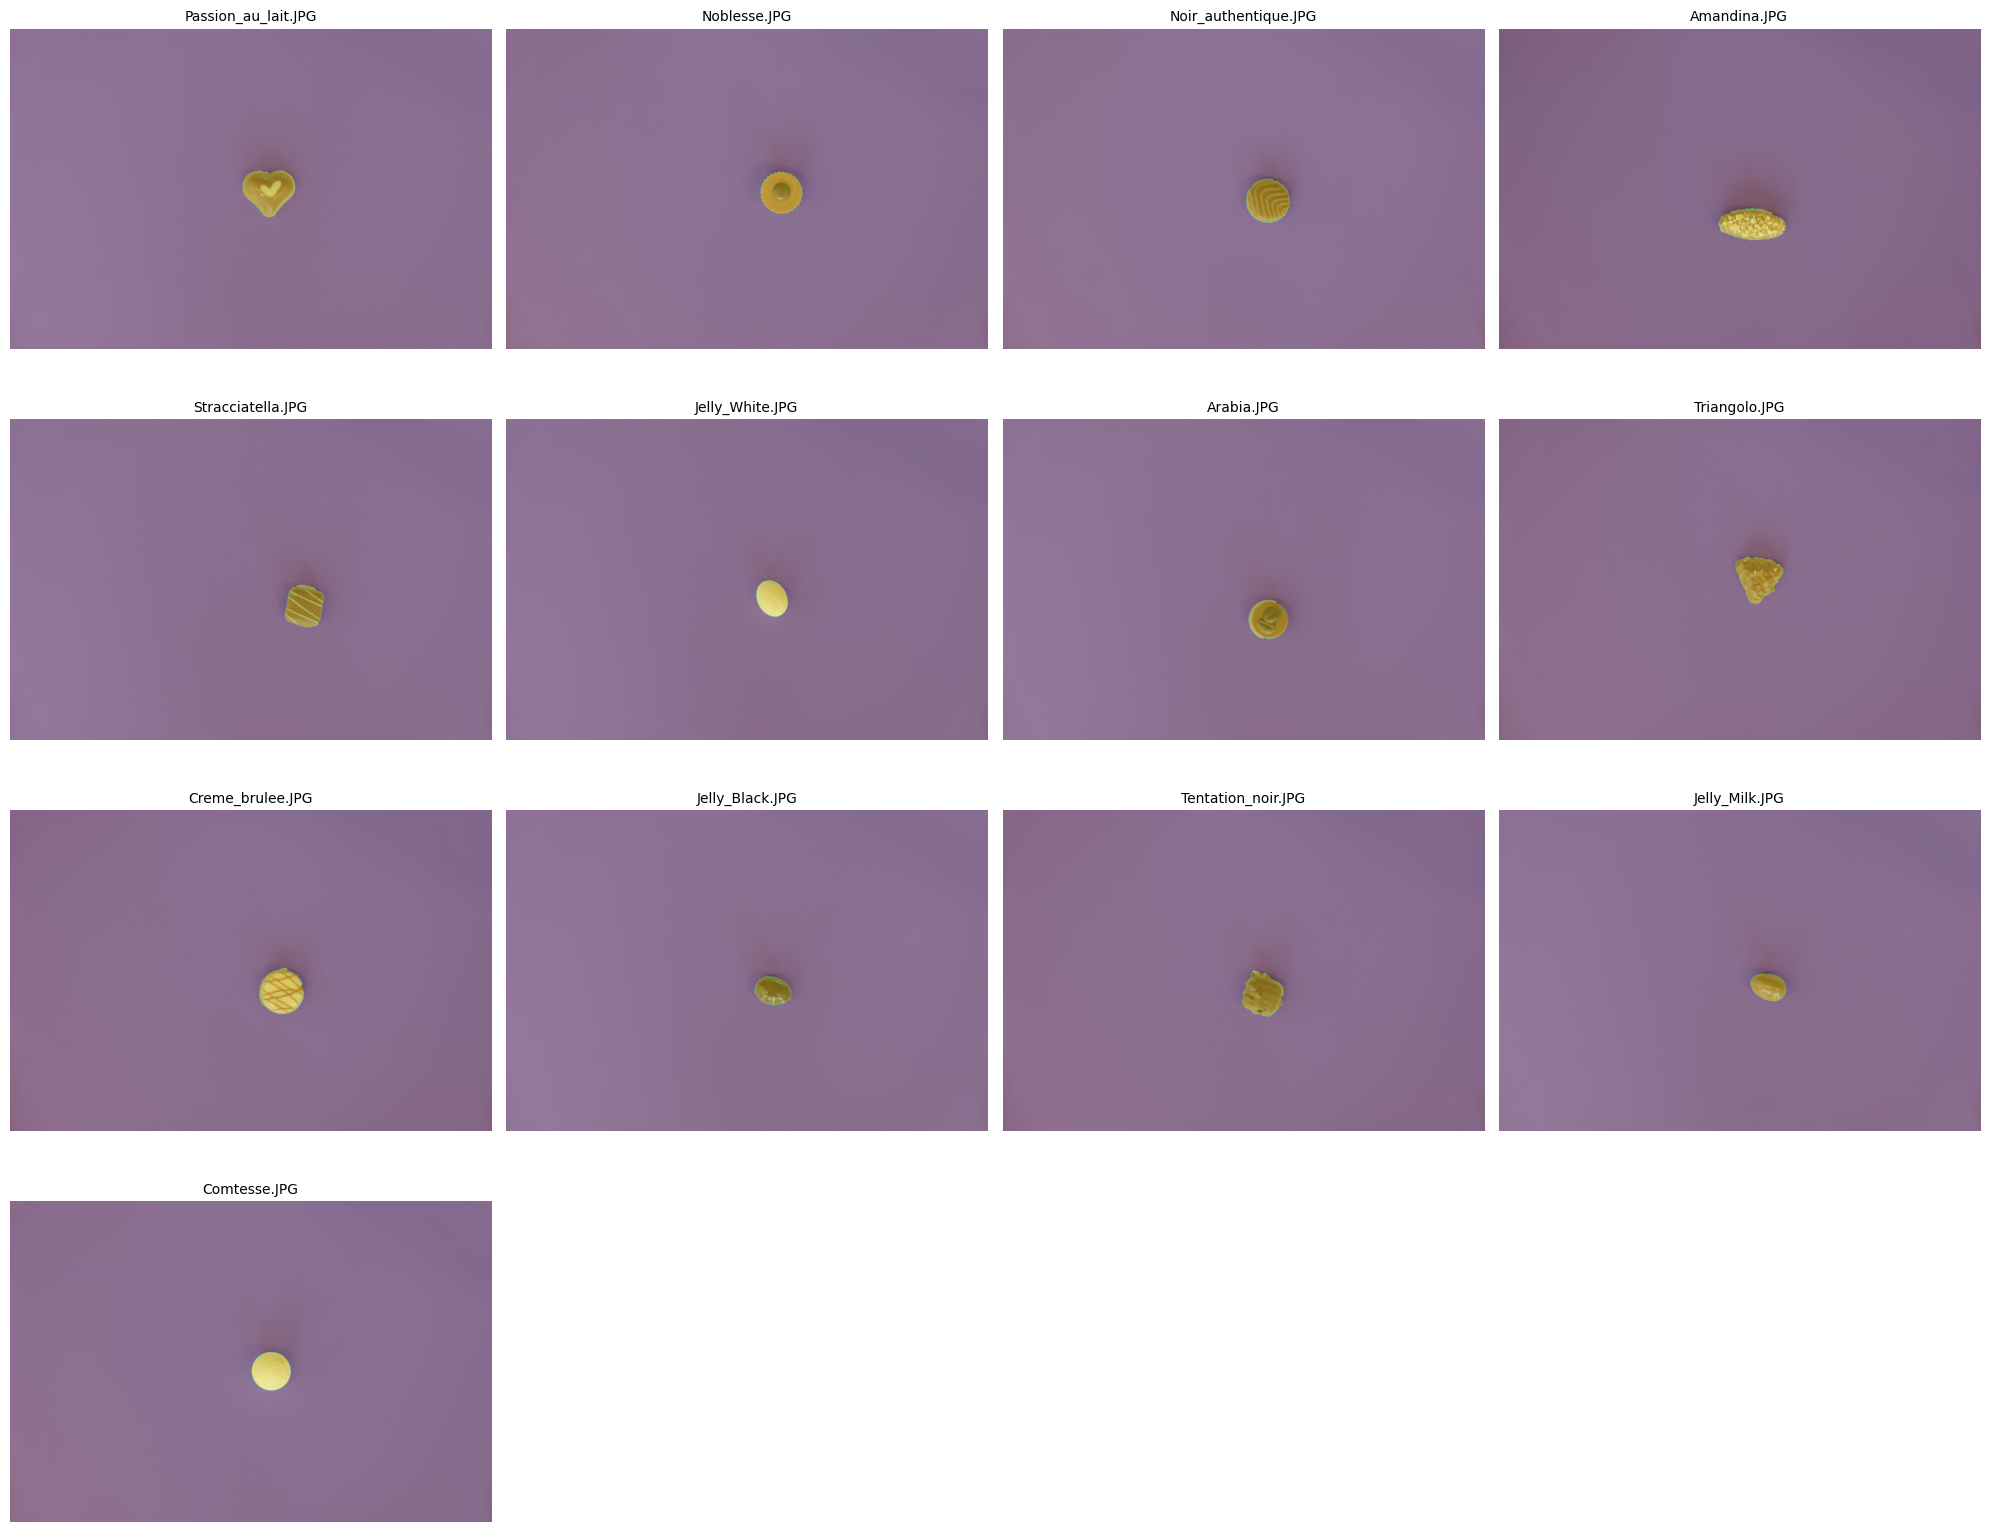

In [10]:
reference_histograms = []
cols = 4
rows = int(np.ceil(len(ref_image_names) / cols))
plt.figure(figsize=(20, 4 * rows))

for i, (img_rgb, mask) in enumerate(zip(ref_images_rgb, masks)):
    img_rgb = img_rgb.copy()
    mask_uint8 = (mask.astype(np.uint8)) * 255

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    eroded_mask = cv2.erode(mask_uint8, kernel, iterations=1)

    hist = cv2.calcHist([img_rgb], [0, 1, 2], eroded_mask, [16, 16, 16], [0, 256]*3)
    hist = cv2.normalize(hist, hist).flatten()
    reference_histograms.append(hist)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_rgb)
    plt.imshow(mask, cmap='viridis', alpha=0.4)
    plt.title(ref_image_names[i], fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [19]:
train_dir = 'chocolate-recognition-classic/dataset_project_iapr2025/train/'
train_image_names = sorted(os.listdir(train_dir))
train_images = [cv2.imread(os.path.join(train_dir, train_image_names[i])) for i in range(len(train_image_names))]
train_images = [cv2.resize(img, (img.shape[1] // 4, img.shape[0] // 4)) for img in train_images]
train_images_rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in train_images]
train_images_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in train_images]

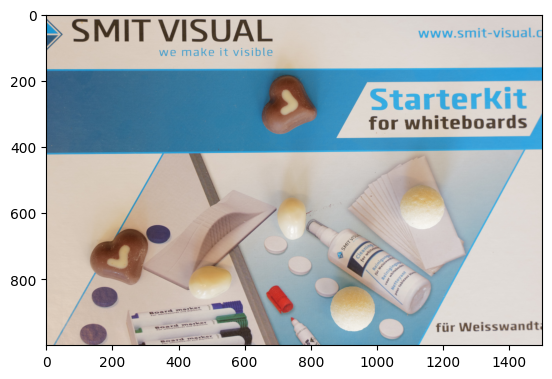

In [20]:
plt.imshow(train_images_rgb[42])

Apply sliding window to the training data

In [22]:
window_size = 80
stride = 10

percentile = 96

heatmaps= []
for img in train_images_rgb:
    heatmap, _ = sliding_window_compare(img, reference_histograms, window_size=window_size, stride=stride)
    threshold = np.percentile(heatmap, percentile)
    heatmap = np.where(heatmap >= threshold, heatmap, 0)
    heatmaps.append(heatmap)

Detect number of hotspots

In [33]:
def plot_heatmap_result(
    filtered_heatmaps, images_rgb, blobs, window_size, stride, idx: int
):
    resized_heatmap = cv2.resize(
        filtered_heatmaps[idx],
        (images_rgb[idx].shape[1], images_rgb[idx].shape[0]),
        interpolation=cv2.INTER_LINEAR,
    )

    # Create a translation matrix to shift by half stride
    M = np.float32([[1, 0, window_size // 2], [0, 1, window_size // 2]])
    resized_heatmap = cv2.warpAffine(
        resized_heatmap, M, (resized_heatmap.shape[1], resized_heatmap.shape[0])
    )

    plt.figure(figsize=(15, 9))

    # Plot original image with heatmap overlay
    plt.imshow(images_rgb[idx])
    plt.imshow(
        resized_heatmap, cmap="hot", alpha=0.5
    )  # Overlay heatmap with 50% transparency

    # Add circles for detected blobs
    for y, x, r in blobs[idx]:
        # Scale coordinates and radius by stride
        y_scaled, x_scaled = (
            y * stride + window_size // 2,
            x * stride + window_size // 2,
        )
        r_scaled = r * stride
        circle = plt.Circle(
            (x_scaled, y_scaled), r_scaled, color="cyan", fill=False, linewidth=2
        )
        plt.gca().add_patch(circle)

    plt.title("Original Image with Heatmap Overlay")
    plt.colorbar(label="Similarity")
    plt.tight_layout()
    plt.axis("off")
    plt.show()
    os.makedirs("images", exist_ok=True)
    plt.savefig(f"images/heatmap_{idx}.png", bbox_inches='tight', dpi=300)

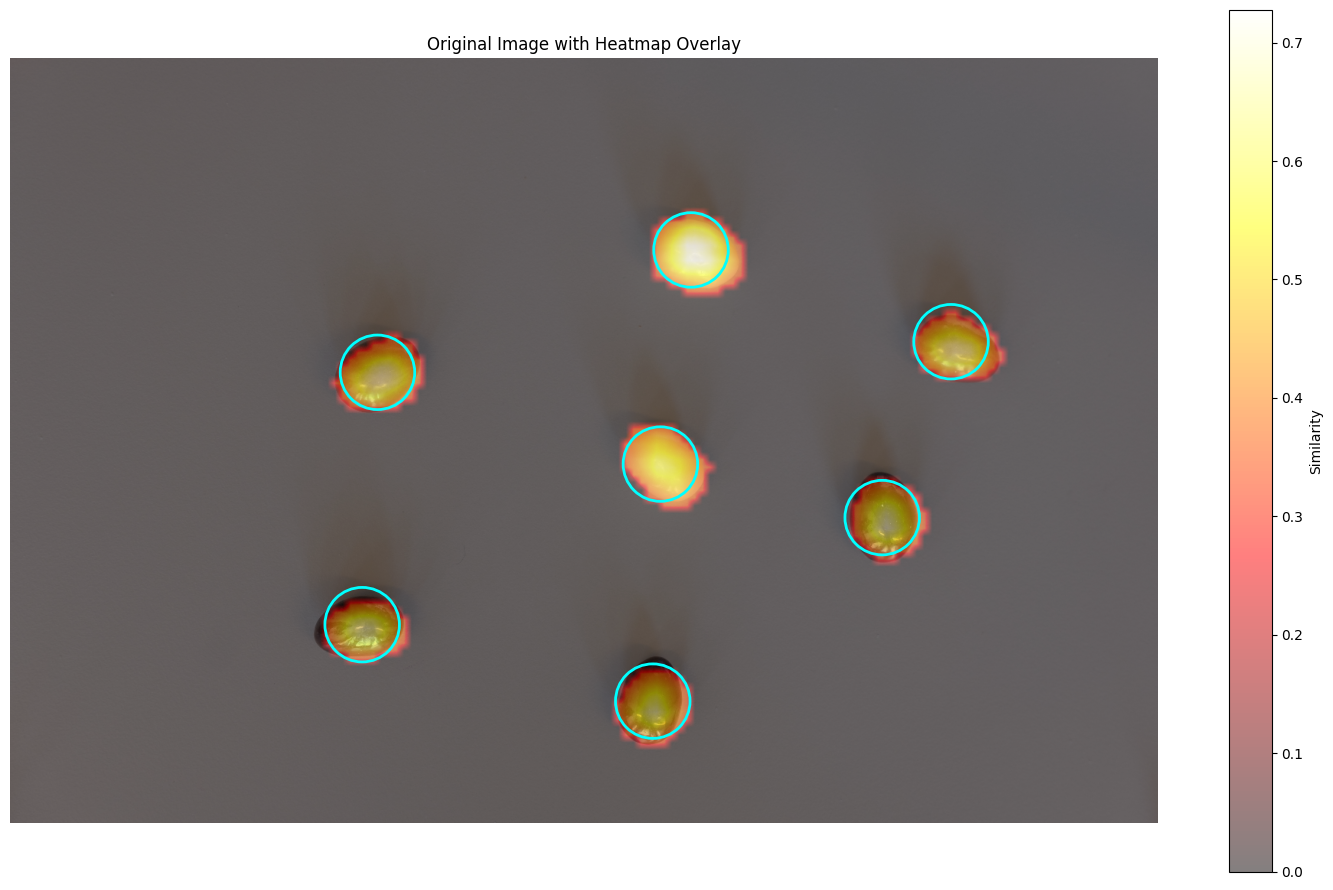

"plt.imshow(heatmaps[42], cmap='hot')\nfor y, x, r in blobs[42]:\n    c = plt.Circle((x, y), r, color='lime', linewidth=2, fill=False)\n    plt.gca().add_patch(c)\nplt.axis('off')\nplt.show()"

<Figure size 640x480 with 0 Axes>

In [34]:
from skimage.feature import blob_log
from sklearn.cluster import DBSCAN

blobs = []
for heatmap in heatmaps:
    blobs.append(blob_log(heatmap, min_sigma=2, max_sigma=15, threshold=0.1))

merged_blobs_all = []
for blob_list in blobs:
    if len(blob_list) == 0:
        merged_blobs_all.append([])
        continue

    positions = blob_list[:, :2]

    clustering = DBSCAN(eps=stride, min_samples=1).fit(positions)

    merged = []
    for label in np.unique(clustering.labels_):
        members = blob_list[clustering.labels_ == label]
        y_mean = np.mean(members[:, 0])
        x_mean = np.mean(members[:, 1])
        r_max = np.max(members[:, 2]) * np.sqrt(2) 
        merged.append((y_mean, x_mean, r_max))
    
    merged_blobs_all.append(merged)

blobs = merged_blobs_all

plot_heatmap_result(
    heatmaps, train_images_rgb, blobs, window_size=window_size, stride=stride, idx=8
)


'''plt.imshow(heatmaps[42], cmap='hot')
for y, x, r in blobs[42]:
    c = plt.Circle((x, y), r, color='lime', linewidth=2, fill=False)
    plt.gca().add_patch(c)
plt.axis('off')
plt.show()'''

Extract patches around the detected hotspots

In [588]:
import importlib
from utils import *
utils = importlib.import_module('utils')
importlib.reload(utils)

<module 'utils' from '/home/hthums/master_projects/IAPR/project/project/utils.py'>

In [589]:
patches_ = []
for img, blob in zip(train_images_rgb, blobs):
    patches_.append(extract_patches_from_blobs(img, blob, stride=stride, window_size=window_size, enlarge_pixels=0))

In [590]:
resized_patches = []
for patch in patches_:
    resized_patch = []
    for p in patch:
        rp = cv2.resize(p, (min_size[1], min_size[0])) 
        resized_patch.append(rp)
    resized_patches.append(resized_patch)

Calculate some descriptors for the patches and do PCA like for the reference images

In [591]:
patch_features = []
for i, patch in enumerate(resized_patches):
    feature = []
    for p in patch:
        feature.append(extract_features(p, feature_list=feature_list))
    patch_features.append(feature)

In [592]:
patch_feature_array = np.vstack(patch_features)

patch_array = pca.transform(patch_feature_array) # use same PCA model !!!

patch_counts = [len(patches) for patches in patch_features]

reduced_features = []

start = 0
for count in patch_counts:
    end = start + count
    reduced_features.append(patch_array[start:end])
    start = end

print("Shape of reduced feature vectors:", len(reduced_features), len(reduced_features[0]), len(reduced_features[0][0]))

train_array = np.vstack(reduced_features)

Shape of reduced feature vectors: 90 12 31


In [593]:
# Map the patches to the images for classification
patch_image_indices = []

for image_idx, patches in enumerate(patch_features):
    n_patches = len(patches)
    patch_image_indices.extend([image_idx] * n_patches)

patch_image_indices = np.array(patch_image_indices)

Patch features shape: 90 12 42
True


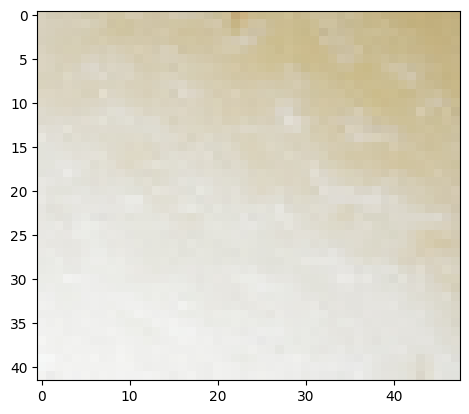

In [594]:
print("Patch features shape:", len(patch_features), len(patch_features[0]), len(patch_features[0][0]))
print(len(patch_features)==len(train_image_names))

plt.imshow(resized_patches[0][0])

Classify the patches

In [595]:
# reference_feature_vectors is a list with length equal to the number of reference images (chocolates)
# reference_feature_vectors[i] is a list with length equal to the number of patches in the i-th reference image
# reference_feature_vectors[i][j] is a feature vector of the j-th patch in the i-th reference image

# patch_features is a list with length equal to the number of training images
# patch_features[i] is a list with length equal to the number of patches in the i-th training image (1 patch per chocolate)
# patch_features[i][j] is a feature vector of the j-th patch in the i-th training image (j-th chocolate)

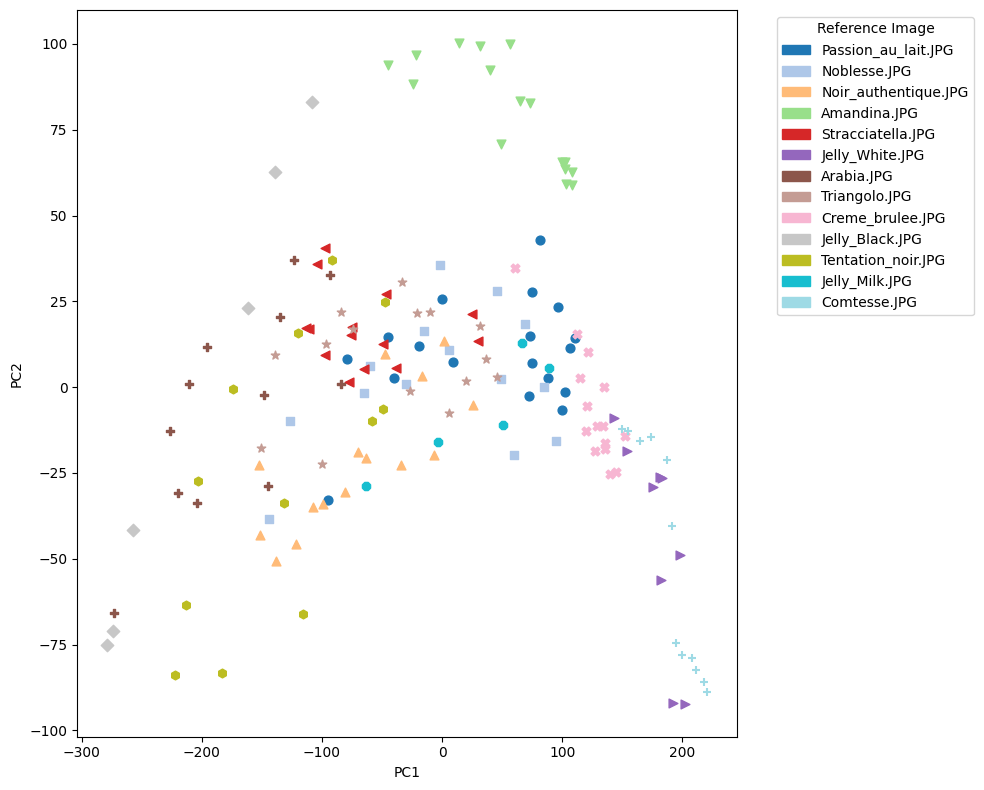

In [596]:
from sklearn.cluster import KMeans
from matplotlib.patches import Patch

k = 13
kmeans = KMeans(n_clusters=k, random_state=0)
cluster_labels = kmeans.fit_predict(reduced_array)

patch_origins = np.array([item[0] for item in selected_bbox_coords])

# Reduce to 2D for plotting
pca_2d = PCA(n_components=2)
reduced_2d = pca_2d.fit_transform(reduced_array)

cmap = plt.get_cmap('tab20')
colors = cmap(patch_origins / max(patch_origins)) 
markers = ['o', 's', '^', 'v', '<', '>', 'P', '*', 'X', 'D', 'h', '8', '+']

plt.figure(figsize=(10, 8))

for i, name in enumerate(ref_image_names):
    idx = patch_origins == i
    plt.scatter(
        reduced_2d[idx, 0], reduced_2d[idx, 1],
        c=[cmap(i / max(patch_origins))], 
        marker=markers[i], 
        s=40,
        label=name
    )

legend_handles = [Patch(color=cmap(i / max(patch_origins)), label=ref_image_names[i]) for i in range(len(ref_image_names))]

plt.legend(handles=legend_handles, title="Reference Image", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()

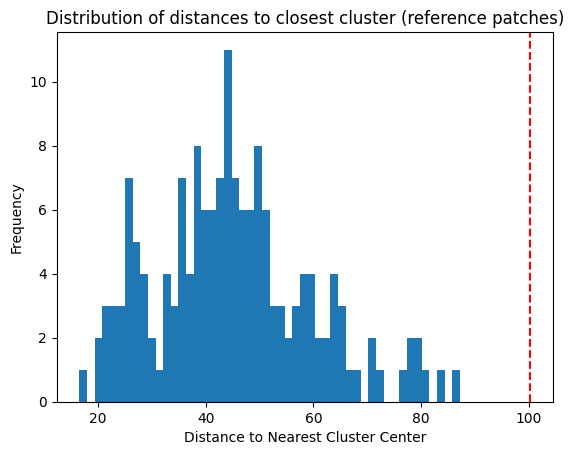

In [597]:
training_cluster_labels = kmeans.predict(train_array)

# OOD analysis
distances = kmeans.transform(train_array)
min_distances = distances.min(axis=1)

reference_distances = kmeans.transform(reduced_array).min(axis=1)
threshold = np.percentile(min_distances, 95)

plt.hist(reference_distances, bins=50)
plt.axvline(threshold, color='r', linestyle='--')
plt.title("Distribution of distances to closest cluster (reference patches)")
plt.xlabel("Distance to Nearest Cluster Center")
plt.ylabel("Frequency")

is_in_distribution = min_distances < threshold

patch_counts_training = [len(patches) for patches in patch_features]

filtered_labels_per_image = []
start = 0
for count in patch_counts_training:
    end = start + count
    labels = training_cluster_labels[start:end]
    in_dist = is_in_distribution[start:end]
    
    filtered_labels = labels[in_dist]
    filtered_labels_per_image.append(filtered_labels)
    
    start = end

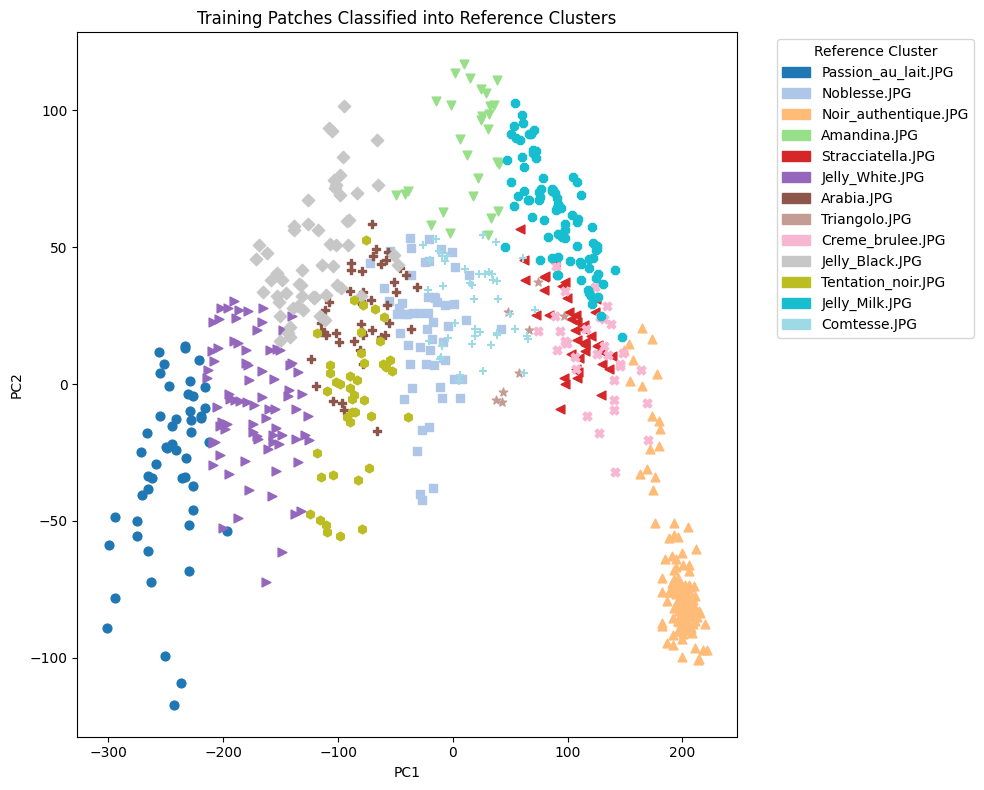

In [598]:
plt.figure(figsize=(10, 8))

for cluster_id in range(k):
    idx = (training_cluster_labels == cluster_id) & is_in_distribution
    plt.scatter(
        train_array[idx, 0], train_array[idx, 1],
        c=[cmap(cluster_id / max(patch_origins))],
        marker=markers[cluster_id],
        s=40,
        label=ref_image_names[cluster_id]
    )


legend_handles = [Patch(color=cmap(i / max(patch_origins)), label=ref_image_names[i]) for i in range(k)]
plt.legend(handles=legend_handles, title="Reference Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Training Patches Classified into Reference Clusters")
plt.tight_layout()
plt.show()

Compare with ground truth

In [599]:
new_train_names = [name.split('L')[1].split('.')[0] for name in train_image_names]
new_ref_names = [
    'Passion au lait',
    'Noblesse',
    'Noir authentique',
    'Amandina',
    'Stracciatella',
    'Jelly White',
    'Arabia',
    'Triangolo',
    'Crème brulée',
    'Jelly Black',
    'Tentation noir',
    'Jelly Milk',
    'Comtesse'
    ]

In [600]:
image_cluster_counts = defaultdict(lambda: [0] * k)

for i, label in enumerate(training_cluster_labels):
    if is_in_distribution[i]:
        image_index = patch_image_indices[i]
        image_id = new_train_names[image_index] 
        image_cluster_counts[image_id][label] += 1
    else:
        image_index = patch_image_indices[i]
        image_id = new_train_names[image_index] 
        image_cluster_counts[image_id][label] += 0

sorted_ids = sorted(image_cluster_counts.keys())


In [601]:
import pandas as pd

df_gt = pd.read_csv('chocolate-recognition-classic/dataset_project_iapr2025/train.csv')

chocolate_classes = new_ref_names 

df_pred = pd.DataFrame.from_dict(image_cluster_counts, orient='index', columns=chocolate_classes)
df_pred = df_pred.reset_index().rename(columns={'index': 'id'}) # name the first column
df_pred = df_pred.sort_values('id').reset_index(drop=True) # sort by id
df_pred = df_pred[df_gt.columns] # sort in same order as df_gt first line (header)

In [602]:
y_true = df_gt.iloc[:, 1:].values
y_pred = df_pred.iloc[:, 1:].values

In [603]:
def f1_score_counts(y_true, y_pred, epsilon=1e-9):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    true_positives = np.minimum(y_true, y_pred).sum(axis=0).astype(float)
    predicted_positives = y_pred.sum(axis=0).astype(float)
    actual_positives = y_true.sum(axis=0).astype(float)
    
    precision = true_positives / (predicted_positives + epsilon)
    recall = true_positives / (actual_positives + epsilon)
    
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    
    macro_f1 = np.mean(f1)
    
    return macro_f1, f1

In [604]:
macro_f1, f1_per_class = f1_score_counts(y_true, y_pred)

print(f"Macro F1 Score (count-based): {macro_f1:.4f}")

for choc, f1_val in zip(df_gt.columns[1:], f1_per_class):
    print(f"{choc}: {f1_val:.4f}")

Macro F1 Score (count-based): 0.2583
Jelly White: 0.2720
Jelly Milk: 0.1864
Jelly Black: 0.1429
Amandina: 0.5714
Crème brulée: 0.4384
Triangolo: 0.0000
Tentation noir: 0.2247
Comtesse: 0.1584
Noblesse: 0.3725
Noir authentique: 0.2766
Passion au lait: 0.1961
Arabia: 0.2268
Stracciatella: 0.2921


Notes (OOD percentile = 97.3%, PCA = 0.95 of cumulated variance)
- Using only histogram features gives F1 score of 0.1693
- Using only LBP features gives F1 score of 0.2349
- glcm not working (cumvar = 0, only 1 component)
- Using only HOG features gives F1 score of 0.1095
- Using only color moments gives F1 score of 0.1956
- Using only gabor features gives F1 score of 0.2260

- LBP + gabor: 0.2514
- LBP + color moments: 0.1509

- LBP + gabor + histogram : 0.2260, 0.2514 optimized for PCA components
- LBP + gabor + histogram + color moments : 0.1865
- LBP + gabor + color moments : 0.1865

Other notes:
- Increasing number of detected blobs by decreasing the threshold for the blob detection increases the F1 score a bit or diminishes it a bit
- Same for sliding window size but more significantly
- Number of PCA components is important also (see above)
- OOD percentile: always excuding nothing, so number of FPs is high but decreasing the threshold for the OOD percentile decreases the F1 score
-